In [1]:
import numpy as np
import os
import fnmatch
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
import matplotlib as mpl
from scipy.optimize import curve_fit
from latexify import latexify
latexify()
#mpl.style.use('classic')
%matplotlib widget 
#%matplotlib ipympl

# Change the working directory
#dir_orig = os.getcwd()
#os.chdir('/')
import PyCrystalField.PyCrystalField as cef

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

 *******************************************************
 *                PyCrystalField 2.3.4                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



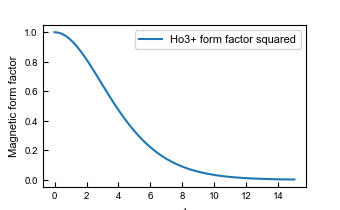

In [2]:
def hoformfact(q):# Gd3+ form factor
    s,j,l,ss = q/(4*np.pi), 8, 6, 2.
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))

    j0 = [0.0566,18.3176,0.3365,7.6880,0.6317,2.9427,-0.0248]
    j2 = [0.2188,18.5157,1.0240,6.7070,0.9251,2.1614, 0.0268]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

q = np.linspace(0,15,101,endpoint=True)
plt.figure()
#plt.plot(q,hoformfact(q),label=r'Ho3+ form factor')
plt.plot(q,cef.RE_FormFactor(q,'Ho3+'),label='Ho3+ form factor squared')
plt.legend(loc='best')
plt.xlabel(r'$Q(\AA^{-1})$')
plt.ylabel(r'Magnetic form factor')
plt.show()

# Plots

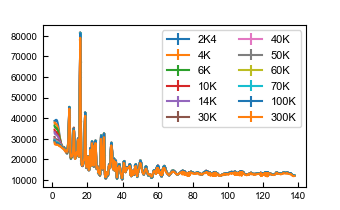

In [3]:
# I-2theta plot
fpath = r'D:\2_Neutron_scattering\11_D4_ILL_2024\processed'
Ts = ['2K4', '4K','6K','10K','14K','30K','40K','50K','60K','70K','100K','300K']

fig, ax = plt.subplots()
for T in Ts:
    fn = 'Ho2GaSbO7_'+T + '.adat'
    dat = np.genfromtxt(os.path.join(fpath, fn),skip_header=14)
    ax.errorbar(x=dat[:,0],y=dat[:,1],yerr=dat[:,2], label=T)

plt.legend(ncols=2)
plt.show()

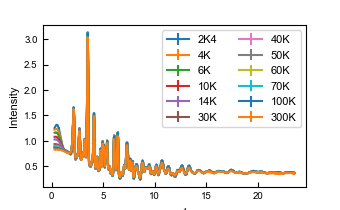

In [4]:
# I-Q plot
fig, ax = plt.subplots()
for T in Ts:
    fn = 'Ho2GaSbO7_'+T + '.corr.q'
    dat = np.genfromtxt(os.path.join(fpath, fn),skip_header=14)
    ax.errorbar(x=dat[:,0],y=dat[:,1],yerr=dat[:,2], label=T)

plt.legend(ncols=2)
ax.set_xlabel(r'$Q(\AA^{-1})$')
ax.set_ylabel(r'Intensity')
plt.show()

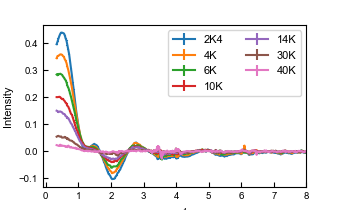

In [5]:
# Corrected I-Q plot
fig, ax = plt.subplots()
for T in Ts[0:7]:
    fn = 'Ho2GaSbO7_'+T + '-50+60+70K.corr.q'
    dat = np.genfromtxt(os.path.join(fpath, fn),skip_header=14)
    ax.errorbar(x=dat[:,0],y=dat[:,1],yerr=dat[:,2], label=T)

plt.legend(ncols=2)

ax.set_xlabel(r'$Q(\AA^{-1})$')
ax.set_ylabel(r'Intensity')
ax.set_xlim([-0.1,8])
plt.show()

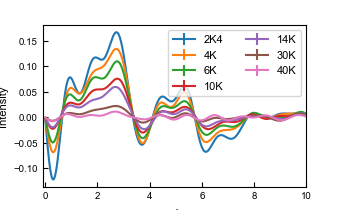

In [6]:
# Fourier transformation
fig, ax = plt.subplots()
for T in Ts[0:7]:
    fn = 'Ho2GaSbO7_'+T + '-50+60+70K.corr.q.perHo.fou.Qmax=7'
    dat = np.genfromtxt(os.path.join(fpath, fn),skip_header=16)
    ax.errorbar(x=dat[:,0],y=dat[:,1],yerr=0*dat[:,2], label=T)

plt.legend(ncols=2)
ax.set_xlabel(r'$r(\AA)$')
ax.set_ylabel(r'Intensity')
ax.set_xlim([-0.1,10])
plt.show()

# Subtract paramagnetic for 100K

In [7]:
fn = 'Ho2GaSbO7_' + '100K' + '.corr.q'
dat = np.genfromtxt(os.path.join(fpath, fn),skip_header=14)


('Data', 'Ho3+ ff', 'Subtraction')


interactive(children=(FloatSlider(value=0.86, description='x1', max=2.0, min=0.5, step=0.01), FloatSlider(valu…

<function __main__.pltSub(x1=0, x2=0)>

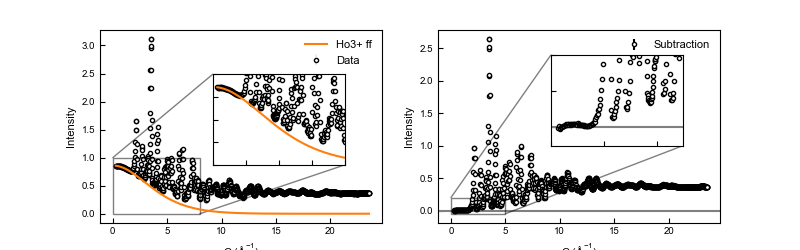

In [8]:
#　Check　Sm(2t:5-45)- a*Sm(2t:25-45)-b subtraction and plot
fig_label = (r'Data', r'Ho3+ ff','Subtraction')
print(fig_label)

def pltSub(x1=0,x2=0):
    global fig, axs, factor, const
    
    axs[0].cla() 
    axs[0].errorbar(x=dat[:,0],y=dat[:,1],yerr=dat[:,2],lw=0.1,
                    ms=3, mec='black', mfc='white',fmt='o',ecolor='black',label=fig_label[0])
    ff = x1*hoformfact(dat[:,0]) + x2
    axs[0].plot(dat[:,0], ff,label=fig_label[1],zorder=30)
    
    # inset Axes....
    x1, x2, y1, y2 = 0, 8, 0, 1  # subregion of the original image
    axins = axs[0].inset_axes([0.4, 0.3, 0.47, 0.47],xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.errorbar(x=dat[:,0],y=dat[:,1],yerr=dat[:,2],lw=0.1,
                    ms=3, mec='black', mfc='white',fmt='o',ecolor='black',label=fig_label[0])
    axins.plot(dat[:,0], ff,label=fig_label[1],zorder=30)
    axs[0].indicate_inset_zoom(axins, edgecolor="black")
    
    axs[0].legend(loc='best',numpoints=1,frameon=False)
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')
    axs[1].errorbar(x=dat[:,0],y=dat[:,1]-ff, yerr=dat[:,2], 
                    ms=3.,fmt='o', mec='black', mfc='white',ecolor='black', label=fig_label[2])
    
    # inset Axes....
    x1, x2, y1, y2 = 0, 5, -0.05, 0.2  # subregion of the original image
    axins = axs[1].inset_axes([0.4, 0.4, 0.47, 0.47],xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.errorbar(x=dat[:,0],y=dat[:,1]-ff, yerr=dat[:,2], 
                    ms=3.,fmt='o', mec='black', mfc='white',ecolor='black', label=fig_label[2])
    axins.axhline(y=0.0, c='grey')
    axs[1].indicate_inset_zoom(axins, edgecolor="black")
    
    axs[1].legend(loc='best',numpoints=1, frameon=False)
    
    #ax.set_yscale('log')
    axs[0].set_xlabel(r'$Q\ (\mathrm{\AA^{-1}})$')
    axs[0].set_ylabel('Intensity')
    axs[1].set_xlabel(r'$Q\ (\mathrm{\AA^{-1}})$')
    axs[1].set_ylabel('Intensity')

    factor=x1; const=x2
    return #fig

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(8,2.5))

interact(pltSub, 
         x1=widgets.FloatSlider(min=0.5,max=2,step=0.01,value=0.86),
         x2=widgets.FloatSlider(min=0,max=1,step=0.1,value=0))

In [60]:
gfactor = 21.5 # from MH fitting (notebook xt_fit.ipynb)
ueff = 10.7 # MT fitting 15-30K, with Tcw=-0.11 (notebook Powder_MH_fit_spin...)
0.07265*10.7*2/11*2/3

0.09422484848484848